In [1]:
%pip install yfinance
%pip install cvxopt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from pandas import DataFrame as df
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import math

In [3]:
ticker_list = ['^GSPC', '^KS11', '^GDAXI', '^HSI', '^FTSE', '^N225', '^BSESN', '^FCHI' , '000001.SS' , '^BFX' , '^MXX']
index_name = ['Shanghai', 'BEL20', 'BSESensex', 'CAC40', 'FTSE100' , 'DAX' , 'S&P500', 'HANG SENG', 'KOSPI', 'Mexico' , 'Nikkei']


data = yf.download(tickers = ticker_list, period = "8y" , interval = "1d")
close = data['Close']
close.columns = index_name
close.dropna(inplace=True)

close

[*********************100%***********************]  11 of 11 completed


<ipython-input-3-3f3d073da376>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close.dropna(inplace=True)


,Shanghai,BEL20,BSESensex,CAC40,FTSE100,DAX,S&P500,HANG SENG,KOSPI,Mexico,Nikkei
Date,,,,,,,,,,,
2015-06-01,4828.737793,3700.429932,27848.990234,5025.299805,6953.600098,11436.049805,2111.729980,27597.160156,2102.370117,44760.101562,20569.869141
2015-06-02,4910.526855,3689.590088,27188.380859,5004.459961,6928.299805,11328.799805,2109.600098,27466.720703,2078.639893,44931.480469,20543.189453
2015-06-03,4909.978027,3721.760010,26837.199219,5034.169922,6950.500000,11419.620117,2114.070068,27657.470703,2063.159912,44732.718750,20473.509766
2015-06-04,4947.102051,3692.070068,26813.419922,4987.129883,6859.200195,11340.599609,2095.840088,27551.890625,2072.860107,44561.109375,20488.189453
2015-06-05,5023.096191,3646.689941,26768.490234,4920.740234,6804.600098,11197.150391,2092.830078,27260.160156,2068.100098,44561.941406,20460.900391
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,3296.469971,3736.570068,61963.679688,7478.160156,7771.000000,16223.990234,4192.629883,19678.169922,2557.080078,53466.320312,31086.820312
2023-05-23,3246.239990,3731.409912,61981.789062,7378.709961,7763.000000,16152.860352,4145.580078,19431.250000,2567.550049,53123.218750,30957.769531
2023-05-24,3204.750000,3656.280029,61773.781250,7253.459961,7627.100098,15842.129883,4115.240234,19115.929688,2567.449951,53393.398438,30682.679688


In [4]:
def cal_rt(data):
    # Calculate daily return of each asset
    rt = df((data-data.shift(1))/data.shift(1))
    rt = rt.dropna()

    return rt

In [5]:
# Calculate daily return
daily_return = cal_rt(close)

# Calculate EWMA of daily return
ewma_daily_return = daily_return.ewm(span=100).mean()

# Calculate annual return from EWMA daily return
annual_return = (1+ewma_daily_return.mean())**252-1


In [6]:
# Calculate EWMA covariance of daily return
ewma_daily_cov = daily_return.ewm(span=100).cov().dropna()

# Annualize the covariance
annual_cov = ewma_daily_return.cov() * 252


In [7]:
display(daily_return)

,Shanghai,BEL20,BSESensex,CAC40,FTSE100,DAX,S&P500,HANG SENG,KOSPI,Mexico,Nikkei
Date,,,,,,,,,,,
2015-06-02,0.016938,-0.002929,-0.023721,-0.004147,-0.003638,-0.009378,-0.001009,-0.004727,-0.011287,0.003829,-0.001297
2015-06-03,-0.000112,0.008719,-0.012917,0.005937,0.003204,0.008017,0.002119,0.006945,-0.007447,-0.004424,-0.003392
2015-06-04,0.007561,-0.007977,-0.000886,-0.009344,-0.013136,-0.006920,-0.008623,-0.003817,0.004702,-0.003836,0.000717
2015-06-05,0.015361,-0.012291,-0.001676,-0.013312,-0.007960,-0.012649,-0.001436,-0.010588,-0.002296,0.000019,-0.001332
2015-06-08,0.021657,-0.006801,-0.009168,-0.012819,-0.002146,-0.011809,-0.006475,0.002059,-0.001407,-0.000401,-0.000181
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,0.003938,-0.000056,0.003791,-0.001842,0.001818,-0.003158,0.000155,0.011701,0.007601,-0.015282,0.009039
2023-05-23,-0.015238,-0.001381,0.000292,-0.013299,-0.001029,-0.004384,-0.011222,-0.012548,0.004095,-0.006417,-0.004151
2023-05-24,-0.012781,-0.020134,-0.003356,-0.016975,-0.017506,-0.019237,-0.007319,-0.016227,-0.000039,0.005086,-0.008886


In [8]:
display(ewma_daily_return)

,Shanghai,BEL20,BSESensex,CAC40,FTSE100,DAX,S&P500,HANG SENG,KOSPI,Mexico,Nikkei
Date,,,,,,,,,,,
2015-06-02,0.016938,-0.002929,-0.023721,-0.004147,-0.003638,-0.009378,-0.001009,-0.004727,-0.011287,0.003829,-0.001297
2015-06-03,0.008328,0.002953,-0.018265,0.000945,-0.000183,-0.000594,0.000571,0.001167,-0.009348,-0.000339,-0.002355
2015-06-04,0.008067,-0.000763,-0.012356,-0.002553,-0.004587,-0.002745,-0.002555,-0.000528,-0.004571,-0.001528,-0.001310
2015-06-05,0.009946,-0.003732,-0.009605,-0.005324,-0.005456,-0.005296,-0.002267,-0.003119,-0.003985,-0.001130,-0.001316
2015-06-08,0.012383,-0.004371,-0.009514,-0.006884,-0.004767,-0.006651,-0.003143,-0.002041,-0.003449,-0.000978,-0.001080
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,0.000321,-0.000112,0.000676,0.001183,0.000321,0.001513,0.000830,-0.000096,0.000903,0.000307,0.002123
2023-05-23,0.000013,-0.000137,0.000668,0.000896,0.000295,0.001396,0.000592,-0.000343,0.000966,0.000174,0.001999
2023-05-24,-0.000241,-0.000533,0.000588,0.000542,-0.000058,0.000987,0.000435,-0.000657,0.000946,0.000271,0.001783


In [9]:
display(annual_return)

Shanghai    -0.054762
BEL20        0.019121
BSESensex    0.134682
CAC40        0.073480
FTSE100      0.019574
DAX          0.061793
S&P500       0.128766
HANG SENG   -0.046787
KOSPI        0.030950
Mexico       0.042716
Nikkei       0.070992
dtype: float64

In [10]:
display(ewma_daily_cov)

Shanghai     BEL20  BSESensex     CAC40   FTSE100  \
Date                                                                      
2015-06-03 Shanghai   0.000145 -0.000099  -0.000092 -0.000086 -0.000058   
           BEL20     -0.000099  0.000068   0.000063  0.000059  0.000040   
           BSESensex -0.000092  0.000063   0.000058  0.000054  0.000037   
           CAC40     -0.000086  0.000059   0.000054  0.000051  0.000034   
           FTSE100   -0.000058  0.000040   0.000037  0.000034  0.000023   
...                        ...       ...        ...       ...       ...   
2023-05-30 S&P500     0.000007  0.000049   0.000016  0.000061  0.000032   
           HANG SENG  0.000096  0.000023   0.000019  0.000024  0.000020   
           KOSPI      0.000035  0.000011   0.000029  0.000015  0.000011   
           Mexico     0.000008  0.000028   0.000008  0.000038  0.000026   
           Nikkei     0.000027  0.000010   0.000025  0.000015  0.000010   

                           DAX    S&P500  HANG SENG     KOSPI    Mexico  \
Date                                                                      
2015-06-03 Shanghai  -0.000148 -0.000027  -0.000099 -0.000033  0.000070   
           BEL20      0.000101  0.000018   0.000068  0.000022 -0.000048   
           BSESensex  0.000094  0.000017   0.000063  0.000021 -0.000045   
           CAC40      0.000088  0.000016   0.000059  0.000019 -0.000042   
           FTSE100    0.000060  0.000011   0.000040  0.000013 -0.000028   
...                        ...       ...        ...       ...       ...   
2023-05-30 S&P500     0.000060  0.000125   0.000007  0.000012  0.000040   
           HANG SENG  0.000017  0.000007   0.000259  0.000075  0.000033   
           KOSPI      0.000019  0.000012   0.000075  0.000100  0.000019   
           Mexico     0.000032  0.000040   0.000033  0.000019  0.000084   
           Nikkei     0.000024  0.000013   0.000036  0.000045  0.000005   

                        Nikkei  
Date                            
2015-06-03 Shanghai   0.000018  
           BEL20     -0.000012  
           BSESensex -0.000011  
           CAC40     -0.000011  
           FTSE100   -0.000007  
...                        ...  
2023-05-30 S&P500     0.000013  
           HANG SENG  0.000036  
           KOSPI      0.000045  
           Mexico     0.000005  
           Nikkei     0.000093  

[17083 rows x 11 columns]

In [11]:
display(annual_cov)

,Shanghai,BEL20,BSESensex,CAC40,FTSE100,DAX,S&P500,HANG SENG,KOSPI,Mexico,Nikkei
Shanghai,0.000893,0.000136,-0.000007,0.000162,0.000138,0.000187,0.000184,0.000386,0.000160,0.000088,0.000214
BEL20,0.000136,0.000301,0.000253,0.000305,0.000216,0.000305,0.000213,0.000233,0.000259,0.000195,0.000219
BSESensex,-0.000007,0.000253,0.000592,0.000311,0.000250,0.000322,0.000236,0.000249,0.000362,0.000198,0.000261
CAC40,0.000162,0.000305,0.000311,0.000383,0.000267,0.000364,0.000235,0.000263,0.000273,0.000215,0.000262
FTSE100,0.000138,0.000216,0.000250,0.000267,0.000257,0.000255,0.000165,0.000229,0.000191,0.000170,0.000177
DAX,0.000187,0.000305,0.000322,0.000364,0.000255,0.000414,0.000257,0.000297,0.000327,0.000195,0.000284
S&P500,0.000184,0.000213,0.000236,0.000235,0.000165,0.000257,0.000244,0.000216,0.000257,0.000157,0.000207
HANG SENG,0.000386,0.000233,0.000249,0.000263,0.000229,0.000297,0.000216,0.000543,0.000317,0.000147,0.000251
KOSPI,0.000160,0.000259,0.000362,0.000273,0.000191,0.000327,0.000257,0.000317,0.000459,0.000202,0.000276
Mexico,0.000088,0.000195,0.000198,0.000215,0.000170,0.000195,0.000157,0.000147,0.000202,0.000258,0.000132


In [12]:
def random_weight(n_assets):
    # Generate random weight coefficients ranging from 0 to 1 (to prohibit short selling)
    coef = np.random.rand(n_assets)
    # Normalize coefficient vector
    weight = coef/coef.sum()
    return weight

In [13]:
def init_portfolio(annual_return, annual_cov, n_assets):
    weights = random_weight(n_assets)
    
    # Calculate the expected return and standard deviation of randomly generated portfolio
    mu = annual_return.T @ (weights)
    sigma = math.sqrt(weights.T @ annual_cov @ weights)
    
    return (mu,sigma)

In [14]:
n_assets = len(ticker_list)

for i in range(5):
    # Generate the random portfolio
    rand_portfolio = init_portfolio(annual_return, annual_cov, n_assets)
    print(rand_portfolio)

(0.052194688169241374, 0.016589396361313652)
(0.04760324763996198, 0.015296258632972229)
(0.0447348438774628, 0.01628120852689763)
(0.050703638725636484, 0.01569940208826904)
(0.043563181573812546, 0.015845837598278602)


In [15]:
n_iters = 50000

means = []
stds = []
for i in range(n_iters):
    # Generate the random portfolio
    m,s = init_portfolio(annual_return, annual_cov, n_assets)
    # Portfolio returns and standard deviations are saved
    means.append(m)
    stds.append(s)

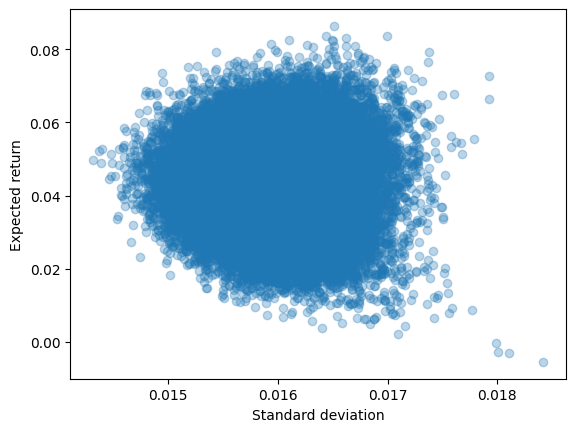

In [16]:
# Plot the portfolio and standard deviations to see the efficient frontier
plt.scatter(x = stds, y = means, alpha = 0.3)
plt.xlabel("Standard deviation")
plt.ylabel("Expected return")
plt.show()

In [17]:
# Define and initialize matrices for convex optimization problem
P = matrix(annual_cov.values)                   # P: covariance matrix
q = matrix(np.zeros(n_assets))                  # q: zero vector (first-order term doesn't exist)
G = np.zeros((2*n_assets+1, n_assets))          # G: 0 <= x <= 1, -annual return
h = np.zeros(2*n_assets +1)                     # h: 0 <= x <= 1, lower bound of portfolio
A = matrix(np.ones(n_assets), (1, n_assets))    # A: [1,...,1]^T
b = matrix([1.0])                               # b: 1

for i in range(2*n_assets+1):
    for j in range(n_assets):
        if i ==j and i<=n_assets:
            # x >= 0
            G[i][j] = -1
        elif (i-n_assets)==j and i>=n_assets:
            # x <= 1
            G[i][j] = 1
        elif i == 2*n_assets:
            # mu * x >= P
            G[i][j] = -annual_return[j]
G = matrix(G)

for i in range(n_assets):
    # x >= 0
    h[i] = 0
    # x <= 1
    h[n_assets + i] = 1
# mu * x >= P
h[2*n_assets] = 1.0
h = matrix(np.transpose(h))

print(G)
print(h)

[-1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00 -1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00 -1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00 -1.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 -1.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]

In [18]:
# Use quadratic problem solver to solve MVO problem
sol = solvers.qp(P, q, G, h, A, b)

print(sol['x'])


     pcost       dcost       gap    pres   dres
 0:  1.2625e-04 -1.4097e+01  1e+01  4e-16  5e-01
 1:  1.2624e-04 -1.4139e-01  1e-01  2e-16  5e-03
 2:  1.2609e-04 -1.8318e-03  2e-03  1e-16  7e-05
 3:  1.1773e-04 -2.1898e-04  3e-04  2e-16  1e-05
 4:  1.0092e-04  3.6696e-05  6e-05  2e-16  7e-20
 5:  9.6325e-05  8.7155e-05  9e-06  2e-16  1e-19
 6:  9.4122e-05  9.3882e-05  2e-07  2e-16  9e-20
 7:  9.4023e-05  9.4020e-05  2e-09  2e-16  8e-20
Optimal solution found.
[ 6.35e-02]
[ 1.14e-05]
[ 5.99e-06]
[ 1.51e-06]
[ 2.35e-01]
[ 1.75e-06]
[ 2.58e-01]
[ 1.93e-05]
[ 5.53e-06]
[ 3.45e-01]
[ 9.90e-02]



In [19]:
weights = np.array(sol['x'])
weights

array([[6.34798874e-02],
       [1.14377803e-05],
       [5.99202795e-06],
       [1.50592615e-06],
       [2.34963734e-01],
       [1.75461850e-06],
       [2.57932635e-01],
       [1.92939382e-05],
       [5.53254317e-06],
       [3.44557293e-01],
       [9.90209330e-02]])

In [20]:
x_ = np.zeros_like(annual_return)
x_[annual_return == max(annual_return)] = 1

# Maximum expected return when portfolio consists of the asset with the highest annaul return
return_max = float(np.transpose(matrix(annual_return)) @ x_)
# Let the minimum return be the portfolio return of optimal portfolio
return_min = float(np.transpose(matrix(annual_return)) @ sol['x'])

In [21]:
# Set the number of sub-intervals
n_iters = 10000

# Divide the interval between max return and min return into sub-intervals
returns = np.zeros(n_iters)
for i in range(n_iters):
    returns[i] = return_min + (return_max-return_min)*i/(n_iters-1)


stds = np.zeros(n_iters)

for i in range(n_iters):
    # For each return, find an optimal portfolio weight
    h[-1] = - returns[i]
    weight = solvers.qp(P, q, G, h, A, b)['x']
    
    stds[i] = float(np.transpose(weight)@annual_cov.values@weight)**0.5

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 3:  1.8663e-04 -2.3138e-01  3e-01  3e-03  9e-04
 4:  2.3404e-04 -2.7149e-02  3e-02  2e-05  5e-06
 5:  2.3396e-04 -1.6262e-04  4e-04  3e-07  7e-08
 6:  2.0749e-04  1.2825e-04  8e-05  5e-08  1e-08
 7:  1.6138e-04  1.4867e-04  1e-05  1e-16  9e-17
 8:  1.5476e-04  1.5451e-04  2e-07  2e-16  8e-17
 9:  1.5459e-04  1.5459e-04  2e-09  2e-16  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2374e-04 -1.1692e+01  5e+01  2e+00  5e-01
 1:  1.2533e-04 -4.9740e+00  7e+00  1e-01  4e-02
 2:  1.5392e-04 -3.1012e+00  5e+00  8e-02  2e-02
 3:  1.8663e-04 -2.3147e-01  3e-01  3e-03  9e-04
 4:  2.3417e-04 -2.7208e-02  3e-02  2e-05  5e-06
 5:  2.3410e-04 -1.6288e-04  4e-04  3e-07  8e-08
 6:  2.0772e-04  1.2848e-04  8e-05  5e-08  1e-08
 7:  1.6158e-04  1.4886e-04  1e-05  2e-16  4e-17
 8:  1.5496e-04  1.5472e-04  2e-07  2e-16  4e-17
 9:  1.5479e-04  1.5479e-04  2e-09  2e-16  7e-17
Optimal solution found.
     pcost       dcost       gap   

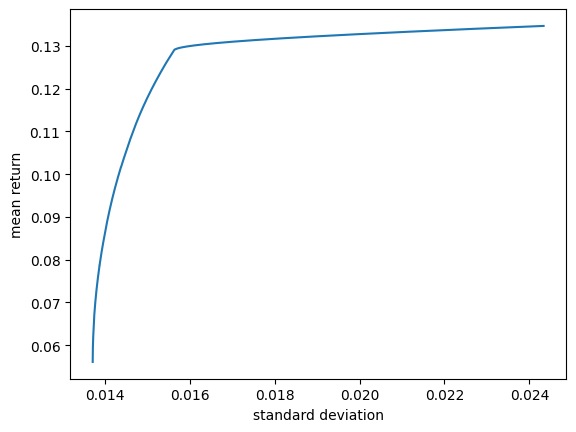

In [22]:
plt.plot(stds, returns)
plt.xlabel("standard deviation")
plt.ylabel("mean return")
plt.show()

In [23]:
%pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [25]:
data = close.copy()
data

,Shanghai,BEL20,BSESensex,CAC40,FTSE100,DAX,S&P500,HANG SENG,KOSPI,Mexico,Nikkei
Date,,,,,,,,,,,
2015-06-01,4828.737793,3700.429932,27848.990234,5025.299805,6953.600098,11436.049805,2111.729980,27597.160156,2102.370117,44760.101562,20569.869141
2015-06-02,4910.526855,3689.590088,27188.380859,5004.459961,6928.299805,11328.799805,2109.600098,27466.720703,2078.639893,44931.480469,20543.189453
2015-06-03,4909.978027,3721.760010,26837.199219,5034.169922,6950.500000,11419.620117,2114.070068,27657.470703,2063.159912,44732.718750,20473.509766
2015-06-04,4947.102051,3692.070068,26813.419922,4987.129883,6859.200195,11340.599609,2095.840088,27551.890625,2072.860107,44561.109375,20488.189453
2015-06-05,5023.096191,3646.689941,26768.490234,4920.740234,6804.600098,11197.150391,2092.830078,27260.160156,2068.100098,44561.941406,20460.900391
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-22,3296.469971,3736.570068,61963.679688,7478.160156,7771.000000,16223.990234,4192.629883,19678.169922,2557.080078,53466.320312,31086.820312
2023-05-23,3246.239990,3731.409912,61981.789062,7378.709961,7763.000000,16152.860352,4145.580078,19431.250000,2567.550049,53123.218750,30957.769531
2023-05-24,3204.750000,3656.280029,61773.781250,7253.459961,7627.100098,15842.129883,4115.240234,19115.929688,2567.449951,53393.398438,30682.679688


<Figure size 1000x600 with 0 Axes>

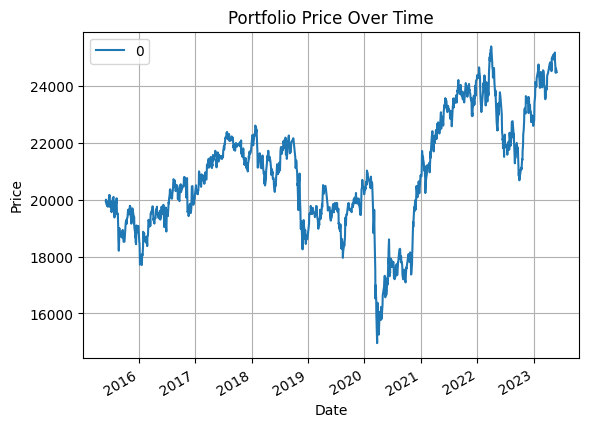

0    0.046954
dtype: float64

In [26]:
weights = np.array(sol['x'])
data = close.copy()
portfolio_price =  data.dot(weights)
portfolio_daily_return = cal_rt(portfolio_price)
portfolio_annual_return = (1+portfolio_daily_return.mean())**252 -1

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
portfolio_price.plot()
plt.title('Portfolio Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

portfolio_annual_return

<Figure size 1000x600 with 0 Axes>

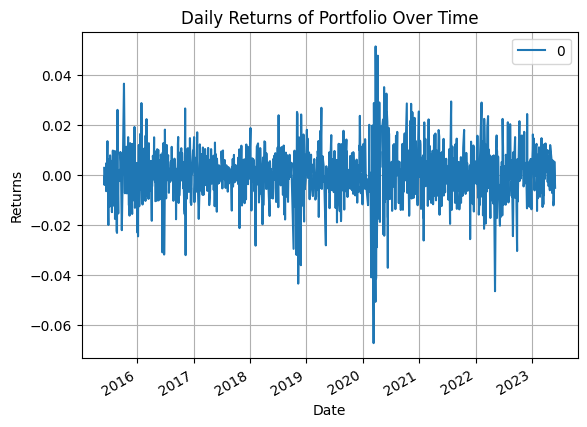

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
portfolio_daily_return.plot()
plt.title('Daily Returns of Portfolio Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# S&P 500과 포트폴리오의 수익률 계산
sp500_returns = close['S&P500'].pct_change().dropna()
portfolio_returns = portfolio_daily_return

sp500_returns

Date
2015-06-02   -0.001009
2015-06-03    0.002119
2015-06-04   -0.008623
2015-06-05   -0.001436
2015-06-08   -0.006475
                ...   
2023-05-22    0.000155
2023-05-23   -0.011222
2023-05-24   -0.007319
2023-05-25    0.008758
2023-05-30    0.014184
Name: S&P500, Length: 1554, dtype: float64

In [29]:
portfolio_returns

,0
Date,
2015-06-02,0.002763
2015-06-03,-0.003452
2015-06-04,-0.004088
2015-06-05,-0.000564
2015-06-08,-0.000330
...,...
2023-05-22,-0.010213
2023-05-23,-0.006020
2023-05-24,0.000958


In [30]:
# 포트폴리오의 일일 수익률과 S&P500의 일일 수익률을 `daily_return` 데이터프레임에 추가
daily_return_array = pd.DataFrame()

daily_return_array['Portfolio'] = portfolio_returns
daily_return_array['SNP500'] = sp500_returns


In [31]:
daily_return_array

,Portfolio,SNP500
Date,,
2015-06-02,0.002763,-0.001009
2015-06-03,-0.003452,0.002119
2015-06-04,-0.004088,-0.008623
2015-06-05,-0.000564,-0.001436
2015-06-08,-0.000330,-0.006475
...,...,...
2023-05-22,-0.010213,0.000155
2023-05-23,-0.006020,-0.011222
2023-05-24,0.000958,-0.007319


<Axes: title={'center': 'Returns of HP and S&P500'}, xlabel='Date'>

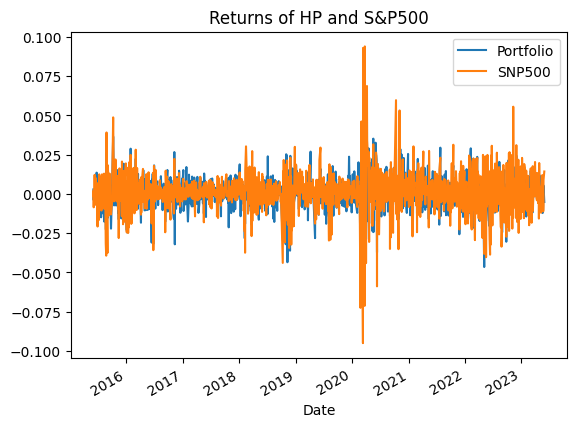

In [32]:
# Visualization of the daily returns
daily_return_array.plot(title = 'Returns of HP and S&P500')

In [33]:
# Linear regression
model = ols("Portfolio ~ SNP500", daily_return_array).fit()

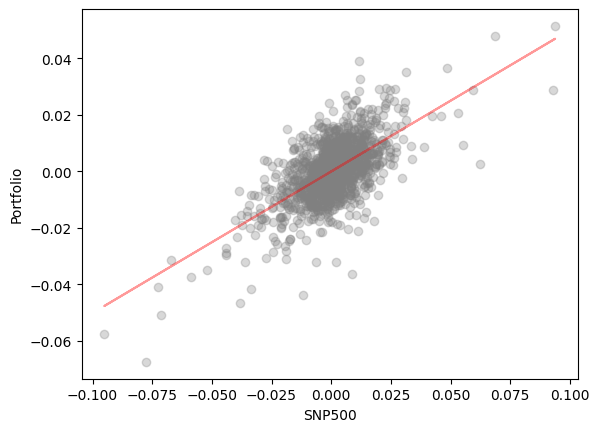

In [34]:
# Get model parameters (alpha and beta)
p = model.params
# Draw scatter plot and linear regression line
plt.scatter(x = daily_return_array['SNP500'], y = daily_return_array['Portfolio'], alpha = 0.3, color = 'gray')
plt.plot(daily_return_array['SNP500'], p.Intercept + p.SNP500 * daily_return_array['SNP500'], 'r-', alpha = 0.4)
plt.xlabel("SNP500")
plt.ylabel("Portfolio")
plt.show()

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Portfolio   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     1075.
Date:                Tue, 30 May 2023   Prob (F-statistic):          1.18e-179
Time:                        15:46:39   Log-Likelihood:                 5364.4
No. Observations:                1554   AIC:                        -1.072e+04
Df Residuals:                    1552   BIC:                        -1.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.093e-05      0.000     -0.416      0.678      -0.000       0.000
SNP500         0.5004      0.015     32.794      0.000       0.470       0.530
==============================================================================
Omnibus:                       81.598   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.590
Skew:                          -0.181   Prob(JB):                     5.20e-56
Kurtosis:                       4.950   Cond. No.                         78.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
anova_results = anova_lm(model)
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
SNP500,1.0,0.063287,0.063287,1075.474285,1.175188e-179
Residual,1552.0,0.091328,0.000059,NaN,NaN
